In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils.validation import check_X_y
from tensorflow import keras
from keras.layers import Input, Dense

from proglearn.progressive_learner import ProgressiveLearner
from proglearn.transformers import NeuralRegressionTransformer
from proglearn.voters import NeuralRegressionVoter
from proglearn.deciders import KNNRegressionDecider

This notebook test the progressive learning regression methodology on a few toy multitasks with known outcomes, to see if it can successfully learn and share representations. In all cases, three tasks are presented. Each are regression of a single real-valued response on a real-valued, $d$ dimensional vector. In all cases, the vector will be scaled, have some known transformation applied to it (common for all tasks), and then another vote-decision function that maps it to the output (which differs for each task). The following three multitask then differ on the following five parameters: how the input is sampled, which common transformer, and which vote-decision to use for each of the three subtasks.

In [2]:
# n is the per-task sample size.
def generate_data(n, d, transform, votes, sigma = 1):
    data = []
    for vote in votes:
        X = np.random.randn(n, d)
        y = vote(transform(X)) + np.random.normal(loc=0.0, scale=sigma, size=n)
        data.append(check_X_y(X, y))
    
    return data

def plot_data(data):
    sns.set(font_scale = 1.5)
    sns.set_style("ticks")
    plt.rcParams["font.family"] = "sans-serif"
    fig, ax = plt.subplots(1, 1, figsize = (5,4))
    
    colors = ["#c51b7d", "#2166ac", "#d95f02"]
    
    for (X, y), color in zip(data, colors):
        if X.shape[1] != 1:
            raise ValueError("X must be one-dimensional to plot.")
        
        ax.scatter(X, y, color = color, marker = ".")    
        ax.set_xlabel('x')
        ax.set_ylabel('y')

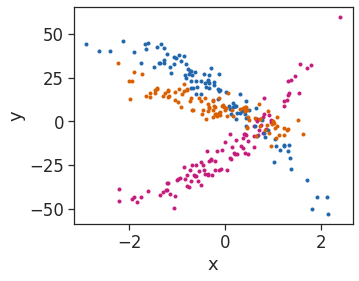

In [3]:
n = 100
d = 1

rep_dim = 29
W = np.random.randn(rep_dim, d)
b = np.random.randn(rep_dim)
v1 = np.random.randn(rep_dim)
v2 = np.random.randn(rep_dim)
v3 = np.random.randn(rep_dim)

data = generate_data(n,
                     d, 
                     lambda X: np.square(np.dot(X, W.T) + b), 
                     [lambda X: np.dot(X, v1), lambda X: np.dot(X, v2), lambda X: np.dot(X, v3)],
                     sigma = 5)

plot_data(data)

# Multitask 1
In this data, we transform by applying a random linear transform followed by an element-wise square. We vote by a random linear combination and add noise.

In [4]:
def build_knn_neural_neural(d):    
    
    default_transformer_class = NeuralRegressionTransformer
        
    # Representation
    network = keras.Sequential()
    network.add(Input(shape=(d,), name = 'input'))
    network.add(Dense(16, activation='relu', name = 'fc0'))
    network.add(Dense(4, activation='relu', name = 'fc1'))          
    
    # Output layer.
    network.add(Dense(1, activation = 'linear', name = 'output'))

    default_transformer_kwargs = {"network" : network, 
                                  "euclidean_layer_idx" : -2,
                                  "optimizer" : keras.optimizers.Adam(1e-3),
                                  "fit_kwargs" : {"epochs" : 20, "verbose" : True}
                                 }

    default_voter_class = NeuralRegressionVoter
    default_voter_kwargs = {"input_dim" : 4, 
                            "verbose" : True,
                            "epochs" : 20,
                            "lr" : 1e-3
                           }
    default_decider_class = KNNRegressionDecider
    
    return ProgressiveLearner(default_transformer_class = default_transformer_class, 
                              default_transformer_kwargs = default_transformer_kwargs,
                              default_voter_class = default_voter_class,
                              default_voter_kwargs = default_voter_kwargs, 
                              default_decider_class = default_decider_class,
                              default_decider_kwargs = {})

In [5]:
n = 100
d = 10

rep_dim = 15
W = np.random.randn(rep_dim, d)
b = np.random.randn(rep_dim)
v1 = np.random.randn(rep_dim)
v2 = np.random.randn(rep_dim)
v3 = np.random.randn(rep_dim)

data = generate_data(n,
                     d, 
                     lambda X: np.square(np.dot(X, W.T) + b), 
                     [lambda X: np.dot(X, v1), lambda X: np.dot(X, v2), lambda X: np.dot(X, v3)],
                     sigma = 5)

In [6]:
# Initialize prog. learner.
knn_neural_neural = build_knn_neural_neural(d)

# Populate with tasks.
for j in range(2):
    print("Fitting task:", j)
    X, y = data[j]
    knn_neural_neural.add_task(X = X, y = y, task_id = j, transformer_voter_decider_split = [0.6, 0.2, 0.2])

Adding task: 0
Epoch 1/20
2/2 [==============================] - 0s 3ms/step - loss: 18279.2617 - MAPE: 152.7318 - MAE: 109.6498 - mse: 18279.2617
Epoch 2/20
2/2 [==============================] - 0s 2ms/step - loss: 18268.1875 - MAPE: 154.2400 - MAE: 109.6117 - mse: 18268.1875
Epoch 3/20
2/2 [==============================] - 0s 2ms/step - loss: 18257.9824 - MAPE: 155.4883 - MAE: 109.5773 - mse: 18257.9824
Epoch 4/20
2/2 [==============================] - 0s 2ms/step - loss: 18247.5137 - MAPE: 156.4242 - MAE: 109.5388 - mse: 18247.5137
Epoch 5/20
2/2 [==============================] - 0s 2ms/step - loss: 18237.2324 - MAPE: 158.3204 - MAE: 109.5033 - mse: 18237.2324
Epoch 6/20
2/2 [==============================] - 0s 1ms/step - loss: 18226.9980 - MAPE: 159.2969 - MAE: 109.4681 - mse: 18226.9980
Epoch 7/20
2/2 [==============================] - 0s 1ms/step - loss: 18217.1133 - MAPE: 160.6438 - MAE: 109.4325 - mse: 18217.1133
Epoch 8/20
2/2 [==============================] - 0s 2ms/step

3/3 [==============================] - 0s 65ms/step - loss: 21205.7246 - mae: 109.1270 - val_loss: 24267.5566 - val_mae: 126.1007
Epoch 2/20
3/3 [==============================] - 0s 20ms/step - loss: 21187.2656 - mae: 109.0014 - val_loss: 24266.4629 - val_mae: 126.0974
Epoch 3/20
3/3 [==============================] - 0s 20ms/step - loss: 21202.5723 - mae: 109.1337 - val_loss: 24265.3750 - val_mae: 126.0942
Epoch 4/20
3/3 [==============================] - 0s 20ms/step - loss: 21205.0762 - mae: 109.0936 - val_loss: 24264.2969 - val_mae: 126.0909
Epoch 5/20
3/3 [==============================] - 0s 24ms/step - loss: 21191.8711 - mae: 109.0030 - val_loss: 24263.2129 - val_mae: 126.0877
Epoch 6/20
3/3 [==============================] - 0s 21ms/step - loss: 21183.6523 - mae: 109.0350 - val_loss: 24262.1504 - val_mae: 126.0845
Epoch 7/20
3/3 [==============================] - 0s 23ms/step - loss: 21188.3340 - mae: 109.0363 - val_loss: 24261.1367 - val_mae: 126.0815
Epoch 8/20
3/3 [========

Epoch 20/20
2/2 [==============================] - 0s 28ms/step - loss: 9729.7930 - mae: 78.6812 - val_loss: 11495.8496 - val_mae: 82.0478


In [ ]:
# Predict on each task.